# Preparation for simplex sampling simulations

We need to sample $G$, $C$ from simplex. Calculate different $I(G,C)$, interaction matrix, and the real Jacobian. 

## Theory

We focus on constant supply here. 
$$
\frac{\mathrm{d} S_i}{\mathrm{d} t} = S_i \Big(\sum_{\alpha}G_{i\alpha}R_{\alpha} - \delta_i \Big),\\
\frac{\mathrm{d} R_{\alpha}}{\mathrm{d} t} = h_{\alpha}(R_\alpha) - R_{\alpha}\sum_{i}C_{i\alpha}S_i.
$$
Local Jacobian at fixed point is 
$$
   J^* = \left(\begin{array}{c|c}
       O  & D(S^*)G\\[1.0ex]
     \hline\\[-1.0ex]
     -D(R^*)C^\top   & \frac{\partial h}{\partial R} - D(C^\top S^*)
    \end{array}
    \right).
$$

Doing local mapping to GLV, we have
$$
\frac{\mathrm{d} s}{\mathrm{d} t} = -D(S^*) G \frac{D(R^*)}{D(C^\top S^*)}C^\top s
$$

## Functions

In [1]:
import torch
import numpy as np
import math

Functions to sample $G$, $C$, $S^*$, and calculate $\gamma$ (resource supply).

In [2]:
def SampleSimplex(Ns:int, # number of species
                  Nr:int, # number of resources
                  rho:float, # correlation in smapling G and C
                  ):
    sample = torch.rand(Ns,2,Nr-1).sort().values

    sample1 = torch.zeros(Ns,2,Nr)
    sample1[:,:,1:Nr] = sample

    sample2 = torch.ones(Ns,2,Nr)
    sample2[:,:,0:Nr-1] = sample

    props = sample2 - sample1

    L = torch.tensor([[1, 0],
                 [rho, math.sqrt(1-rho**2)]]) # Cholesky decomposition
    
    L = (torch.sum(L,dim=1)**(-1)).unsqueeze(1) * L # to simplex

    props = torch.matmul(L,props)
    G = props[:,0]
    C = props[:,1]

    Ss = 0.01 + 0.99*torch.rand(Ns)

    gamma = Ss @ C

    return G, C, Ss, gamma

Given $G$, $C$, $S^*$, caculate real Jacobian.

In [3]:
def Jacobian(G:torch.Tensor, # growth rates
             C:torch.Tensor, # consumption rates
             Ss:torch.Tensor, # species abundances S^*
             criterion = 1.0e-3 # larger than which we think is unstable
             ):
    Ns, Nr = G.shape[:2]
    Jstar = torch.zeros(Ns+Nr,Ns+Nr)
    Jstar[0:Ns,Ns:Ns+Nr] = Ss.unsqueeze(1) * G
    Jstar[Ns:Ns+Nr,0:Ns] = - C.transpose(0,1)
    Jstar[Ns:Ns+Nr,Ns:Ns+Nr] = - torch.diag(C.transpose(0,1) @ Ss)

    E_J = torch.linalg.eigvals(Jstar).real
    umodel = len(E_J[E_J >= criterion])/Ns

    return umodel

Calculate variance, mean, and symmetricity of the interaction matrix.

In [4]:
def IntMatrix(G:torch.Tensor, # growth rates
             C:torch.Tensor, # consumption rates
             Ss:torch.Tensor, # species abundances S^*
             ):
    # interaction matrix:
    IM = (G * ((Ss @ C)**(-1)).unsqueeze(0)) @ C.transpose(0,1)

    # normalize
    IM = ((IM.diag())**(-0.5)).unsqueeze(1) * IM * ((IM.diag())**(-0.5)).unsqueeze(0)

    Mask = torch.ones(IM.size()).triu(diagonal=1)==1
    UTri = IM[Mask]
    LTri = IM.transpose(0,1)[Mask]
    
    ndiag = torch.cat((UTri,LTri))
    mean = ndiag.mean()
    sigma = ndiag.std()

    corr = torch.corrcoef(torch.cat((UTri.unsqueeze(0),LTri.unsqueeze(0))))[0,1]
    return mean, sigma, corr

Calculate the original $I(G,C)$

In [5]:
def NormalG(G):
    G = torch.diag((torch.sum(G, 1))**(-1)) @ G
    return G

def Hetero(G):
    Ns = G.shape[0]
    # normaized to the simplex
    G = torch.diag((torch.sum(G, 1))**(-1)) @ G

    # G-G distances
    distances = torch.zeros(Ns,Ns)
    for i in range(Ns-1):
        for j in range(i+1, Ns):
            distances[i,j] = torch.linalg.norm(G[i] - G[j])
    distances = distances + distances.transpose(0,1) + 2*torch.diag(torch.ones(Ns))
    minDis = torch.min(distances, 1).values
    H = torch.mean(minDis)
    return H/2

def I(G,C):
    NG = NormalG(G)
    H = Hetero(G)
    # normaized to the simplex
    C = torch.diag((torch.sum(C, 1))**(-1)) @ C

    # G-C distances
    J = torch.mean(torch.linalg.norm(NG - C, dim=1))

    # G-G distances given by H
    # by definition
    I = J/H
    return I

New measure based on noise-signal ratio

In [6]:
"""
def InewSimplex(G:torch.Tensor, # growth rates
                C:torch.Tensor, # consumption rates on simplex!
                ):
    # calculate Inew for G, C on simplex
    # G-G distances
    [Ns, Nr] = G.size()
    meanG = torch.mean(G,dim=0)
    SSb = torch.zeros(Nr,Nr)
    SSw = torch.zeros(Nr,Nr)

    for i in range(Ns):
        dg = (G[i] - meanG).unsqueeze(1)
        dgc = (C[i] - G[i]).unsqueeze(1)
        SSb = SSb + dg @ dg.transpose(0,1)
        SSw = SSw + dgc @ dgc.transpose(0,1)
    SSb = SSb/Ns
    SSw = SSw/Ns

    _, V = torch.linalg.eigh(SSb)

    I = math.sqrt((V.transpose(0,1) @ (SSw @ torch.linalg.pinv(SSb)) @ V).diag().max())
    return I
"""
# not working

def Heteros(G):
    Ns = G.shape[0]
    # normaized to the simplex
    G = torch.diag((torch.sum(G, 1))**(-1)) @ G

    # G-G distances
    distances = torch.zeros(Ns,Ns)
    for i in range(Ns-1):
        for j in range(i+1, Ns):
            distances[i,j] = torch.linalg.norm(G[i] - G[j])
    distances = distances + distances.transpose(0,1) + 2*torch.diag(torch.ones(Ns))
    minDis = torch.min(distances, 1).values
    
    return minDis/2 # a Ns tensor

def Inew(G:torch.Tensor, # growth rates
         C:torch.Tensor, # consumption rates
        ):
    # normaized to the simplex
    C = torch.diag((torch.sum(C, 1))**(-1)) @ C
    G = torch.diag((torch.sum(G, 1))**(-1)) @ G

    GGdiss = Heteros(G)

    GCdiss = torch.linalg.norm(G - C, dim=1)

    Is = GCdiss/GGdiss

    return Is.mean(), Is.std()

Tests

In [7]:
Ns = 32
G, C, Ss, gamma = SampleSimplex(Ns,32,0.87)

mean, sigma, _ = IntMatrix(G,C,Ss)

print('Jacobian: ',Jacobian(G,C,Ss,1e-3), ' interaction matrix: ', sigma * math.sqrt(Ns) + mean, 'I is', I(G,C),
      'new I is:', Inew(G,C))

Jacobian:  0.0  interaction matrix:  tensor(1.1839) I is tensor(0.9744) new I is: (tensor(0.9876), tensor(0.1774))


$I$ and new $I$ has no big difference, just add std of $I$. :)

## Run!

In [30]:
# Ns from 4 to 48;
# Nr 32;
# each given Ns, Nr; try 144 different \rho;
# output J, Interaction stength, and new I (mean + std)

Nr = 32
Ns_span = [32]
num_rho = 512

rho_span = torch.zeros(num_rho)
rho_span[:int(num_rho/2)] = torch.linspace(0, .869, steps=int(num_rho/2))
rho_span[int(num_rho/2):] = torch.linspace(.87, 1, steps=int(num_rho/2))

outputs = torch.zeros(len(Ns_span),num_rho,4)

for i in range(len(Ns_span)):
    Ns = Ns_span[i]
    for j in range(num_rho):
        rho = rho_span[j]
        G,C,Ss,_ = SampleSimplex(Ns, Nr, rho)
        outputs[i,j,0] = Jacobian(G,C,Ss,5e-4)
        
        mean, sigma, _ = IntMatrix(G,C,Ss)
        outputs[i,j,1] = sigma * math.sqrt(Ns) + mean

        Imean, Istd = Inew(G,C)
        outputs[i,j,2] = Imean
        outputs[i,j,3] = Istd

## Plot

In [46]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

Text(0, 0.5, 'Interaction matrix')

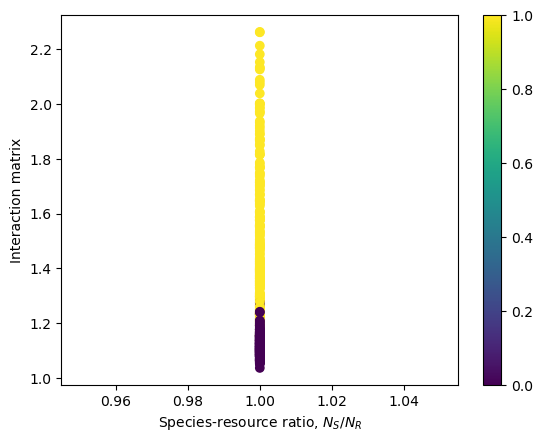

In [32]:
NsNr = (torch.tensor(Ns_span).view(1,len(Ns_span)).transpose(0,1) * torch.ones(1,len(rho_span)))/Nr

unstable = (outputs[:,:,0] > 0).float()
plt.figure()
plt.scatter(NsNr,outputs[:,:,1],c=unstable) # try to plot something like the fraction of unstable states (inside one pixel)
plt.colorbar()

plt.xlabel('Species-resource ratio, $N_S/N_R$')
plt.ylabel('Interaction matrix')

In [33]:
intm_mean = []
uf_mean = []
intm_std = []
uf_std = []

for i in range(100):
    indeces = ((i*0.025<=outputs[:,:,1]) & (outputs[:,:,1]<(i+1)*0.025)).nonzero(as_tuple=True)
    x_group = (outputs[:,:,1])[indeces]
    y_group = unstable[indeces]
    if x_group.size() != torch.Size([0]):
        intm_mean.append(torch.mean(x_group))
        intm_std.append(torch.std(x_group)/math.sqrt(len(indeces[0])))
        uf_mean.append(torch.mean(y_group))
        uf_std.append(torch.std(y_group)/math.sqrt(len(indeces[0])))

Text(0, 0.5, 'Fraction of unstable communities')

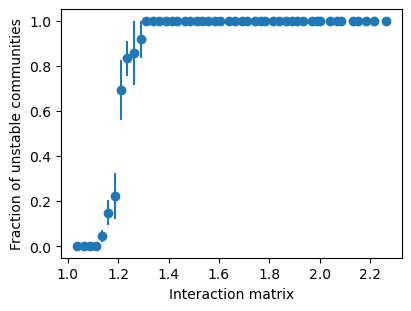

In [34]:
plt.figure(figsize=(4, 3),constrained_layout=True)
plt.errorbar(intm_mean,uf_mean, xerr=intm_std, yerr= uf_std, marker = 'o', ls='none')

plt.xlabel('Interaction matrix')
plt.ylabel('Fraction of unstable communities')

Text(0, 0.5, 'Encroachment')

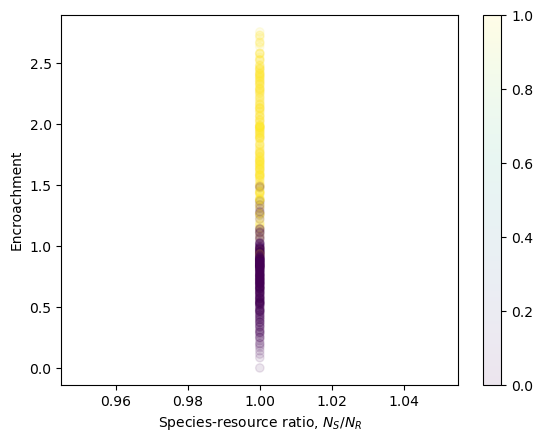

In [35]:
plt.figure()
plt.scatter(NsNr,outputs[:,:,2],c=unstable,alpha=0.1) # try to plot something like the fraction of unstable states (inside one pixel)
plt.colorbar()

plt.xlabel('Species-resource ratio, $N_S/N_R$')
plt.ylabel('Encroachment')

In [36]:
E_mean = []
uf1_mean = []
E_std = []
uf1_std = []

for i in range(60):
    indeces = ((i*0.1<=outputs[:,:,2]) & (outputs[:,:,2]<(i+1)*0.1)).nonzero(as_tuple=True)
    x_group = (outputs[:,:,2])[indeces]
    y_group = unstable[indeces]
    if x_group.size() != torch.Size([0]):
        E_mean.append(torch.mean(x_group))
        E_std.append(torch.std(x_group)/math.sqrt(len(indeces[0])))
        uf1_mean.append(torch.mean(y_group))
        uf1_std.append(torch.std(y_group)/math.sqrt(len(indeces[0])))

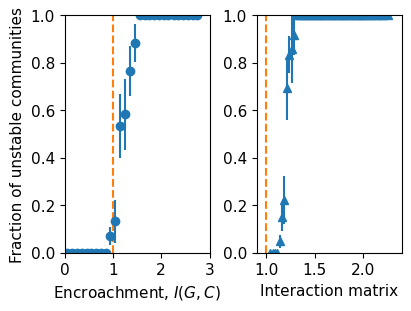

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(4, 3), constrained_layout=True)
axs[0].errorbar(E_mean,uf1_mean, xerr=E_std, yerr= uf1_std, marker = 'o', ls='none')
axs[0].plot(torch.linspace(1.,1.,steps=10),torch.linspace(0.,1.,steps=10), '--')
axs[1].errorbar(intm_mean,uf_mean, xerr=intm_std, yerr= uf_std, marker = '^', ls='none')
axs[1].plot(torch.linspace(1.,1.,steps=10),torch.linspace(0.,1.,steps=10), '--')

axs[0].set_xlim(0,3.0)
axs[0].set_ylim(0,1)

axs[1].set_xlim(0.9,2.4)
axs[1].set_ylim(0,1)

axs[0].set_xlabel('Encroachment, $I(G,C)$')
axs[1].set_xlabel('Interaction matrix')
axs[0].set_ylabel('Fraction of unstable communities')
plt.savefig('../figures/IandIM.eps',format='eps')

In [42]:
len((((outputs[:,:,2] < 1.0) & (unstable == 1.0)).nonzero(as_tuple=True))[0])

3

In [43]:
len((((outputs[:,:,2] > 1.0) & (unstable == 0.0)).nonzero(as_tuple=True))[0])# 93.3

31

In [44]:
len((((outputs[:,:,1] > 1.0) & (unstable == 0.0)).nonzero(as_tuple=True))[0])# 44.7

283